In [ ]:
#Middle East Conflict Prediction Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
import lightgbm as LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install xgboost lightgbm
import warnings

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
import pandas as pd

def main():
    # Load data and let pandas handle headers
    df = pd.read_csv('MiddleEast_2015-2025_Feb21.csv', low_memory=False)

    # Define column names and rename only if needed
    column_names = [
        "event_id_cnty", "event_date", "year", "time_precision",
        "disorder_type", "event_type", "sub_event_type",
        "actor1", "assoc_actor_1", "inter1", "actor2", "assoc_actor_2",
        "inter2", "interaction", "civilian_targeting", "iso",
        "region", "country", "admin1", "admin2", "admin3",
        "location", "latitude", "longitude", "geo_precision",
        "source", "source_scale", "notes", "fatalities", "tags", "timestamp"
    ]

    if df.columns[0] != "event_id_cnty":
        df.columns = column_names

    print(f"Loaded {len(df)} rows of data")
    return df

def preprocess_data(df):
    """
    Preprocess the ACLED dataset for model training
    """
    print("Preprocessing data...")

    # Check the first few rows of the date column to see the format
    print(f"First few rows of event_date:\n{df['event_date'].head()}")

    # Convert event_date to datetime with the correct format '%d/%m/%Y'
    df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce', format='%d/%m/%Y')

    # If there are still NaT (invalid) dates, try to convert them with another format (e.g., '%Y%m%d')
    df.loc[df['event_date'].isna(), 'event_date'] = pd.to_datetime(
        df.loc[df['event_date'].isna(), 'event_date'], format='%Y%m%d', errors='coerce'
    )

    # Print how many rows have invalid dates after conversion
    print(f"Invalid dates (NaT) after conversion: {df['event_date'].isna().sum()} rows")

    # Drop rows with invalid dates
    before_drop = len(df)
    df = df.dropna(subset=['event_date'])
    print(f"Removed {before_drop - len(df)} rows with invalid dates")

    # Convert fatalities to numeric
    df['fatalities'] = pd.to_numeric(df['fatalities'], errors='coerce').fillna(0).astype(int)

    # Define severity levels
    def map_event_to_severity(event_type):
        high_severity = ['Battles', 'Explosions/Remote violence', 'Violence against civilians']
        medium_severity = ['Riots']
        low_severity = ['Protests', 'Strategic developments']

        if event_type in high_severity:
            return 2
        elif event_type in medium_severity:
            return 1
        else:
            return 0

    df['conflict_severity'] = df['event_type'].fillna('').apply(map_event_to_severity)

    # Train-test split
    cutoff_date = pd.to_datetime('2023-01-01')
    train_df = df[df['event_date'] < cutoff_date]
    test_df = df[df['event_date'] >= cutoff_date]

    print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

    return train_df, test_df

In [ ]:
def engineer_features(train_df, test_df):
    """
    Create features for the model while avoiding data leakage.
    """
    print("Engineering features...")

    # Function to extract features from a dataframe
    def extract_features(df, reference_df):
        # Create a copy to avoid modifying the original dataframe
        df_features = df.copy()

        # Extract temporal features
        df_features['month'] = df_features['event_date'].dt.month
        df_features['day_of_week'] = df_features['event_date'].dt.dayofweek
        df_features['quarter'] = df_features['event_date'].dt.quarter

        # Group by reference_df (train_df only) to prevent leakage
        location_freq = reference_df.groupby('location').size().reset_index(name='location_event_count')
        location_severity = reference_df.groupby('location')['conflict_severity'].mean().reset_index(name='location_avg_severity')

        df_features = df_features.merge(location_freq, on='location', how='left')
        df_features = df_features.merge(location_severity, on='location', how='left')

        # Actor-based features
        actor1_freq = reference_df.groupby('actor1').size().reset_index(name='actor1_event_count')
        actor1_severity = reference_df.groupby('actor1')['conflict_severity'].mean().reset_index(name='actor1_avg_severity')

        df_features = df_features.merge(actor1_freq, on='actor1', how='left')
        df_features = df_features.merge(actor1_severity, on='actor1', how='left')

        actor2_freq = reference_df.groupby('actor2').size().reset_index(name='actor2_event_count')
        actor2_severity = reference_df.groupby('actor2')['conflict_severity'].mean().reset_index(name='actor2_avg_severity')

        df_features = df_features.merge(actor2_freq, on='actor2', how='left')
        df_features = df_features.merge(actor2_severity, on='actor2', how='left')

        # Country-level features
        country_freq = reference_df.groupby('country').size().reset_index(name='country_event_count')
        country_severity = reference_df.groupby('country')['conflict_severity'].mean().reset_index(name='country_avg_severity')

        df_features = df_features.merge(country_freq, on='country', how='left')
        df_features = df_features.merge(country_severity, on='country', how='left')

        # Handle missing values
        df_features.fillna(0, inplace=True)

        # Encode categorical variables (basic label encoding for now)
        for col in ['disorder_type', 'sub_event_type', 'country', 'admin1']:
            df_features[col] = df_features[col].astype('category').cat.codes

        # Select relevant features
        features = [
            'time_precision', 'fatalities',
            'month', 'day_of_week', 'quarter',
            'location_event_count', 'location_avg_severity',
            'actor1_event_count', 'actor1_avg_severity',
            'actor2_event_count', 'actor2_avg_severity',
            'country_event_count', 'country_avg_severity',
            'latitude', 'longitude', 'geo_precision',
            'disorder_type', 'sub_event_type', 'country', 'admin1'
        ]

        return df_features[features], df_features['conflict_severity']

    # Extract features from both train and test sets, using train_df as reference
    X_train, y_train = extract_features(train_df, train_df)
    X_test, y_test = extract_features(test_df, train_df)  # Ensure test set uses train-based statistics

    print(f"Created {X_train.shape[1]} features")

    return X_train, y_train, X_test, y_test

In [ ]:
def build_model(X_train, y_train, X_test, y_test):
    """
    Build, train, and evaluate multiple models.
    """
    print("Building and training models...")

    # Identify categorical and numerical features
    categorical_features = ['disorder_type', 'sub_event_type', 'country', 'admin1']
    numerical_features = [col for col in X_train.columns if col not in categorical_features]

    # Define preprocessing steps
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Define models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight="balanced"),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42)
    }

    # Store results
    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")

        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Train model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

        # Store results
        results[name] = {
            'model': pipeline,
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': y_pred
        }

    # Determine the best model based on F1 score
    best_model_name = max(results, key=lambda k: results[k]['f1_score'])
    print(f"\nBest model: {best_model_name} with F1 Score: {results[best_model_name]['f1_score']:.4f}")

    return results, best_model_name

In [ ]:
# 4. Model Evaluation and Analysis
def evaluate_best_model(results, best_model_name, X_test, y_test, numerical_features, categorical_features):
    """
    Detailed evaluation of the best model.
    """
    print("\nDetailed evaluation of the best model:")

    best_model = results[best_model_name]['model']
    y_pred = results[best_model_name]['predictions']

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # If the model supports feature importance, analyze it
    if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
        try:
            # Get feature importance
            model = best_model.named_steps['model']
            if hasattr(model, 'feature_importances_'):
                feature_importance = model.feature_importances_

                # Get feature names after preprocessing
                feature_names = []

                # Numerical features (directly used)
                feature_names.extend(numerical_features)

                # Extract transformed categorical feature names from OneHotEncoder
                preprocessor = best_model.named_steps['preprocessor']
                encoder = preprocessor.transformers_[1][1]  # OneHotEncoder step

                if hasattr(encoder, 'get_feature_names_out'):
                    cat_feature_names = encoder.get_feature_names_out()
                    feature_names.extend(cat_feature_names)
                else:
                    print("Warning: Could not extract feature names from OneHotEncoder")
                    feature_names.extend(categorical_features)  # Fallback

                # Debug: Print expected vs. computed feature names
                expected_features = best_model.feature_names_in_
                print("Expected feature names:", expected_features)
                print("Computed feature names:", feature_names)

                # Ensure the number of features match
                if len(feature_names) == len(feature_importance):
                    # Create a dataframe with feature importances
                    importance_df = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': feature_importance
                    }).sort_values('Importance', ascending=False)

                    # Plot top 20 features
                    plt.figure(figsize=(12, 10))
                    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
                    plt.title(f'Top 20 Feature Importances - {best_model_name}')
                    plt.tight_layout()
                    plt.savefig('feature_importance.png')
                    plt.show()

                    print("\nTop 10 Most Important Features:")
                    print(importance_df.head(10))
                else:
                    print(f"Feature length mismatch! Expected {len(feature_importance)}, but got {len(feature_names)}")

        except Exception as e:
            print(f"Could not plot feature importance: {e}")

    return best_model

In [ ]:
# 5. Time-based Performance Analysis
def analyze_temporal_performance(test_df, y_test, y_pred):
    """
    Analyze how model performance varies over time.
    """
    print("\nAnalyzing model performance over time...")

    # Create a DataFrame with event dates, actual values, and predictions
    time_df = pd.DataFrame({
        'event_date': test_df['event_date'].reset_index(drop=True),
        'actual': y_test.reset_index(drop=True),
        'predicted': y_pred
    })

    # Extract month-year as a datetime object for sorting
    time_df['month_year'] = time_df['event_date'].dt.to_period('M')

    # Calculate monthly accuracy
    monthly_accuracy = time_df.groupby('month_year').apply(
        lambda x: accuracy_score(x['actual'], x['predicted'])
    ).reset_index(name='accuracy')

    # Convert `month_year` back to string for plotting (ensures proper axis labeling)
    monthly_accuracy['month_year'] = monthly_accuracy['month_year'].astype(str)

    # Plot monthly accuracy
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='month_year', y='accuracy', data=monthly_accuracy, marker='o')
    plt.xticks(rotation=45)
    plt.title('Model Accuracy Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('temporal_performance.png')
    plt.show()

    # Analyze prediction errors by conflict severity
    error_by_severity = time_df[time_df['actual'] != time_df['predicted']]

    if not error_by_severity.empty:
        severity_counts = error_by_severity['actual'].value_counts().sort_index()

        plt.figure(figsize=(10, 6))
        severity_counts.plot(kind='bar', color='red')
        plt.title('Distribution of Prediction Errors by Actual Conflict Severity')
        plt.xlabel('Conflict Severity')
        plt.ylabel('Number of Errors')
        plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'], rotation=0)
        plt.tight_layout()
        plt.savefig('error_by_severity.png')
        plt.show()
    else:
        print("No prediction errors detected.")

    return monthly_accuracy

In [ ]:
# 6. Spatial Analysis
def analyze_spatial_performance(test_df, y_test, y_pred, min_samples=10):
    """
    Analyze how model performance varies by country.
    Filters out countries with fewer than `min_samples` test samples.
    """
    print("\nAnalyzing model performance by country...")

    # Create a DataFrame with test data and predictions
    spatial_df = pd.DataFrame({
        'country': test_df['country'].reset_index(drop=True),
        'actual': y_test.reset_index(drop=True),
        'predicted': y_pred
    })

    # Calculate accuracy by country
    country_stats = spatial_df.groupby('country').agg(
        accuracy=('actual', lambda x: accuracy_score(x, spatial_df.loc[x.index, 'predicted'])),
        num_samples=('actual', 'count')
    ).reset_index()

    # Filter out countries with very few test samples
    country_stats = country_stats[country_stats['num_samples'] >= min_samples]

    # Sort by number of samples first (descending), then accuracy
    country_stats = country_stats.sort_values(by=['num_samples', 'accuracy'], ascending=[False, True])

    # Plot country-wise accuracy
    plt.figure(figsize=(14, 10))
    sns.barplot(x='accuracy', y='country', data=country_stats, palette="viridis")
    plt.title('Model Accuracy by Country')
    plt.xlabel('Accuracy')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.savefig('spatial_performance.png')
    plt.show()

    return country_stats

In [ ]:
# 7. Model Deployment Functions
import pickle
import joblib

def save_model(model, filename='conflict_prediction_model.pkl', use_joblib=False):
    """
    Save the trained model to a file.
    Use joblib for large models (default: pickle).
    """
    if use_joblib:
        joblib.dump(model, filename)
    else:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model(filename='conflict_prediction_model.pkl', use_joblib=False):
    """
    Load a trained model from a file.
    """
    if use_joblib:
        model = joblib.load(filename)
    else:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

def predict_future_conflicts(model, new_data):
    """
    Make predictions on new data using the trained model's pipeline.
    """
    try:
        # Ensure new_data is a DataFrame and has the correct features
        if not isinstance(new_data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame.")

        expected_features = model.named_steps['preprocessor'].get_feature_names_out()
        missing_features = set(expected_features) - set(new_data.columns)

        if missing_features:
            raise ValueError(f"Missing features in input data: {missing_features}")

        # Predict using the trained model
        predictions = model.predict(new_data)

        # Map predictions to human-readable labels
        severity_labels = {0: 'Low severity', 1: 'Medium severity', 2: 'High severity'}
        predicted_labels = [severity_labels[pred] for pred in predictions]

        return predicted_labels

    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

Loading and preprocessing data...
Preprocessing data...
First few rows of event_date:
0    21/02/2025
1    21/02/2025
2    21/02/2025
3    21/02/2025
4    21/02/2025
Name: event_date, dtype: object
Invalid dates (NaT) after conversion: 0 rows
Removed 0 rows with invalid dates
Training set size: 208393, Test set size: 153799
Performing feature engineering...
Engineering features...
Created 20 features
Building and training models...
Building and training models...
Training Random Forest...
Random Forest - Accuracy: 0.9380, F1 Score: 0.9184
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9250, F1 Score: 0.8913
Training XGBoost...
XGBoost - Accuracy: 0.9250, F1 Score: 0.8913
Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2209
[LightGBM] [Info] Number of data points in the train set: 208393, number of used features: 249
[LightGBM] [Info] Start training from score -0.996335
[LightGBM] [Info] Start training from score -2.403815
[LightGBM] [Info] Start training from score -0.615451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - Accuracy: 0.9250, F1 Score: 0.8913

Best model: Random Forest with F1 Score: 0.9184

Detailed evaluation of the best model:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58714
           1       0.89      0.17      0.28     11207
           2       0.90      1.00      0.95     83878

    accuracy                           0.94    153799
   macro avg       0.93      0.72      0.74    153799
weighted avg       0.94      0.94      0.92    153799



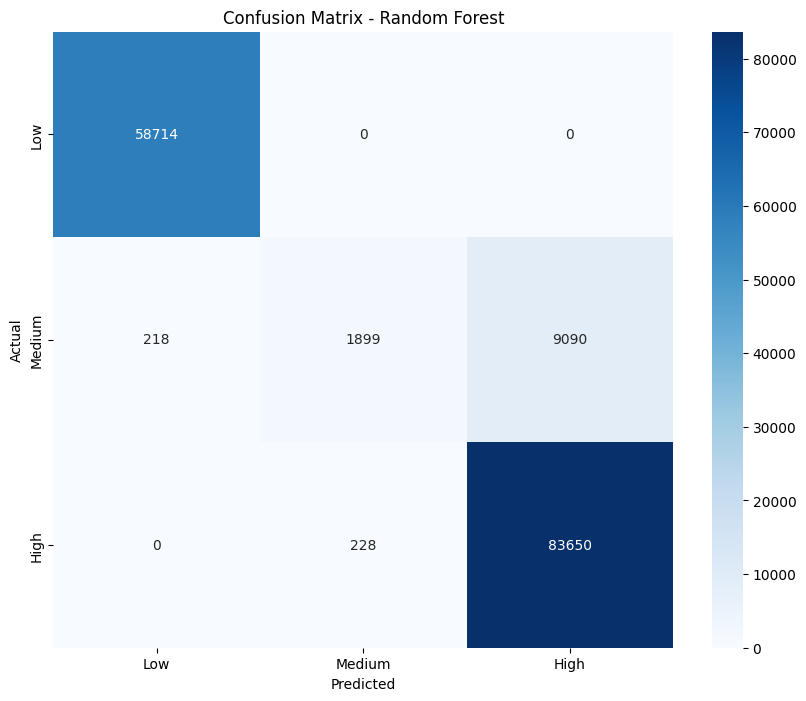

Expected feature names: ['time_precision' 'fatalities' 'month' 'day_of_week' 'quarter'
 'location_event_count' 'location_avg_severity' 'actor1_event_count'
 'actor1_avg_severity' 'actor2_event_count' 'actor2_avg_severity'
 'country_event_count' 'country_avg_severity' 'latitude' 'longitude'
 'geo_precision' 'disorder_type' 'sub_event_type' 'country' 'admin1']
Computed feature names: ['fatalities', 'latitude', 'longitude', 'timestamp', 'disorder_type_0', 'disorder_type_1', 'disorder_type_2', 'disorder_type_3', 'sub_event_type_0', 'sub_event_type_1', 'sub_event_type_2', 'sub_event_type_3', 'sub_event_type_4', 'sub_event_type_5', 'sub_event_type_6', 'sub_event_type_7', 'sub_event_type_8', 'sub_event_type_9', 'sub_event_type_10', 'sub_event_type_11', 'sub_event_type_12', 'sub_event_type_13', 'sub_event_type_14', 'sub_event_type_15', 'sub_event_type_16', 'sub_event_type_17', 'sub_event_type_18', 'sub_event_type_19', 'sub_event_type_20', 'sub_event_type_21', 'sub_event_type_22', 'sub_event_ty

<ipython-input-7-ad9a812648bc>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_accuracy = time_df.groupby('month_year').apply(


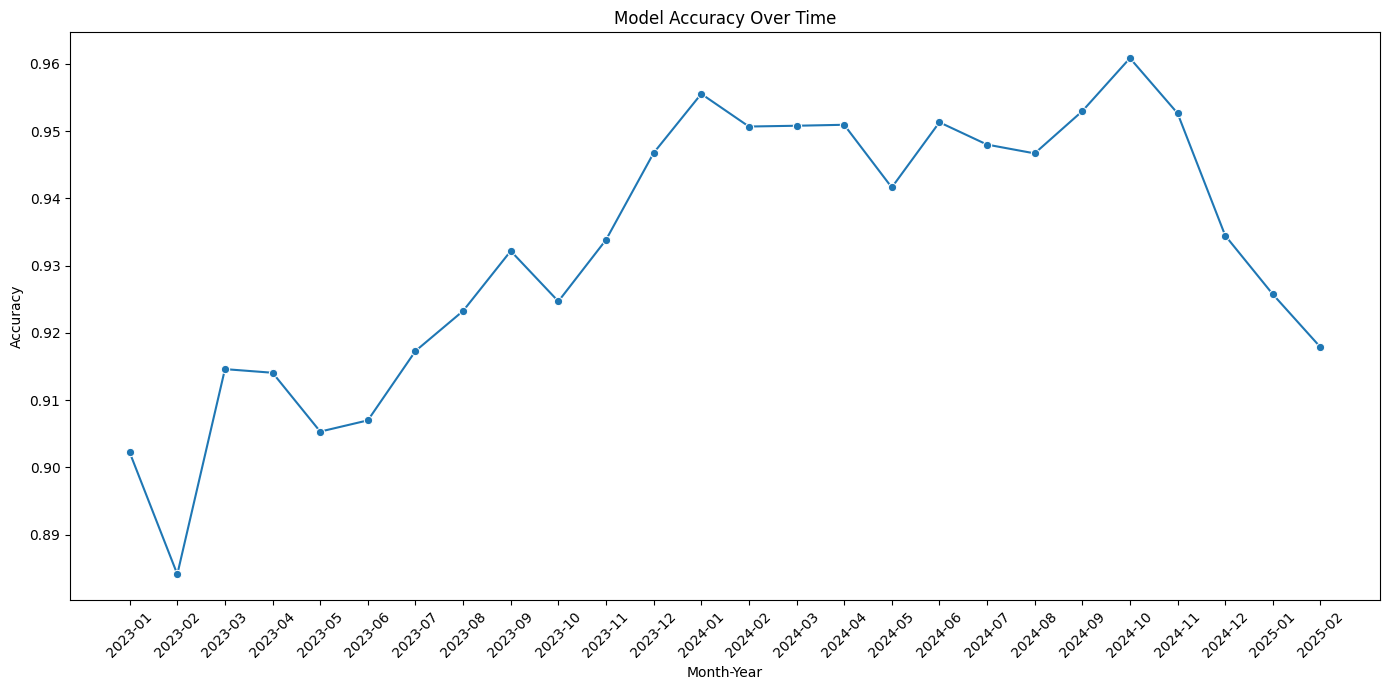

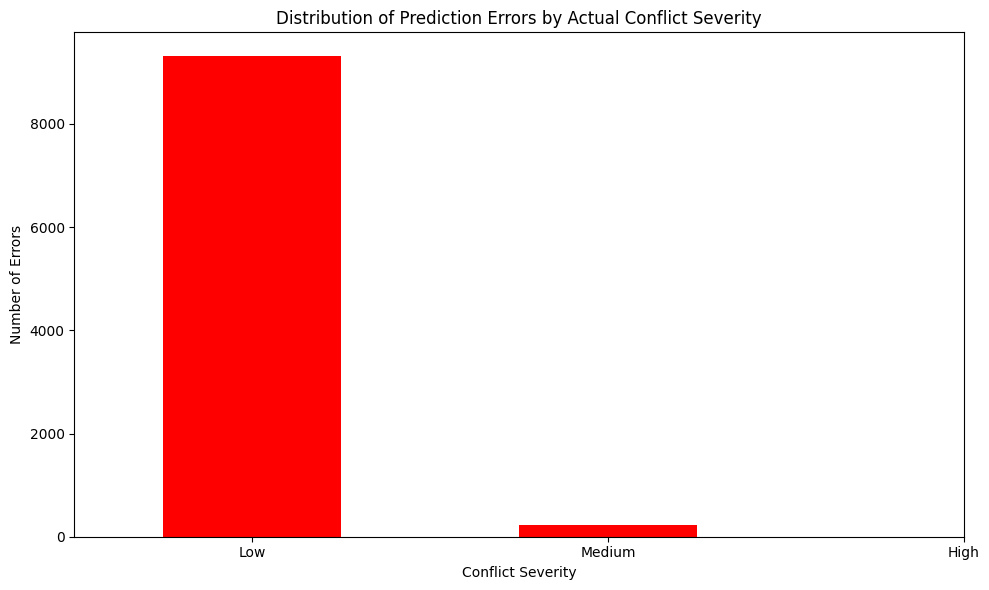

Analyzing spatial performance...

Analyzing model performance by country...


<ipython-input-8-21d7a28a9a35>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='accuracy', y='country', data=country_stats, palette="viridis")


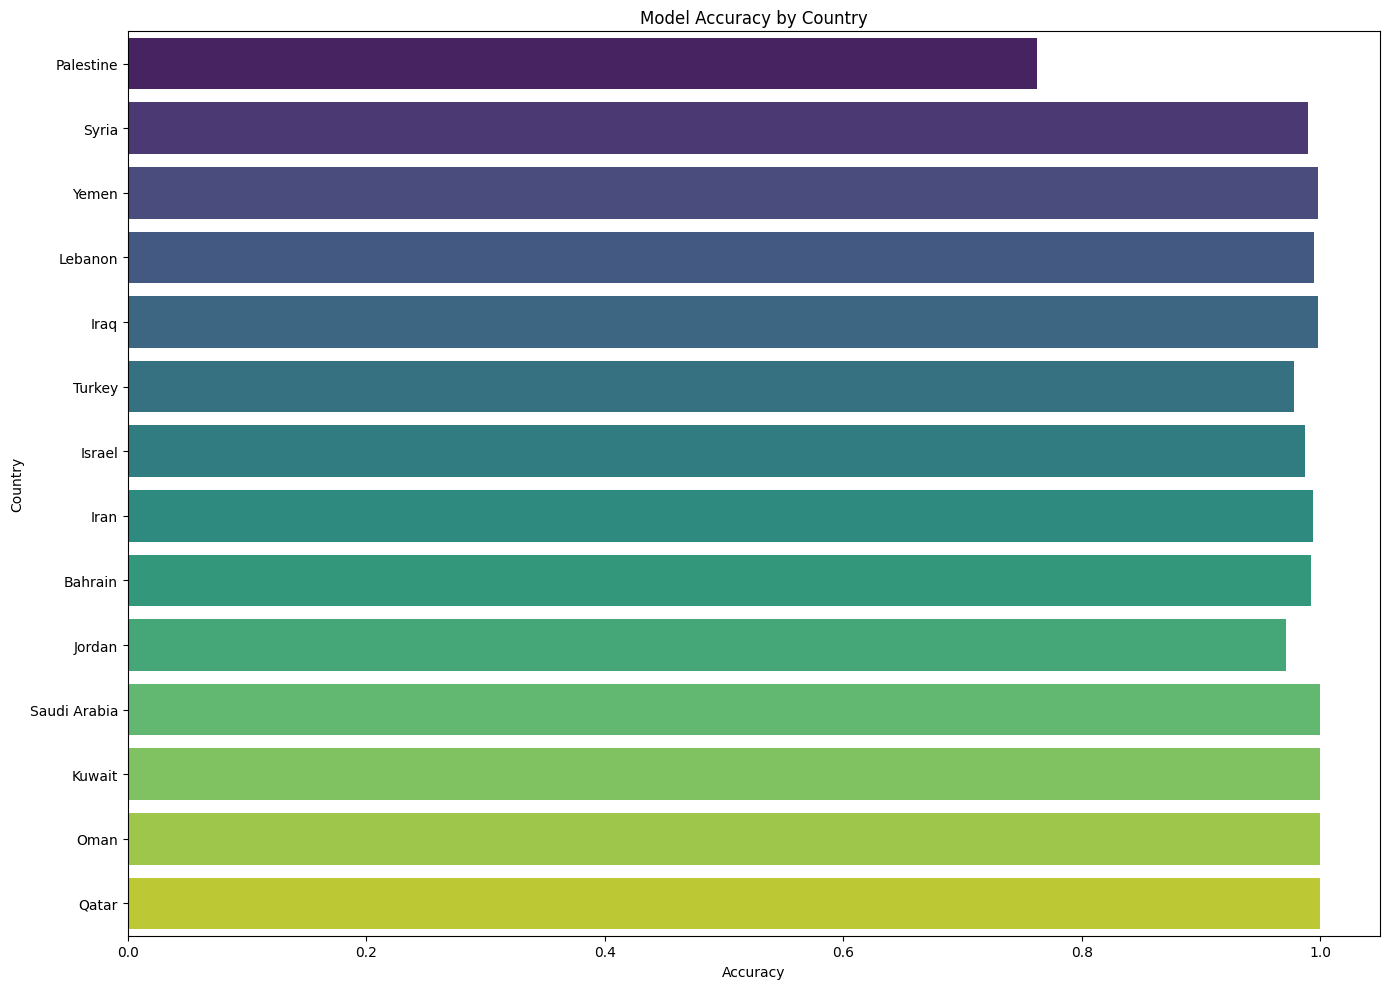

Saving the best model: Random Forest
Model saved to conflict_prediction_model.pkl

Complete pipeline executed successfully.
Best model: Random Forest
Overall test accuracy: 0.9380
Overall test F1 score: 0.9184


In [ ]:
def main(file_path):
    """
    Run the entire conflict prediction pipeline.
    """
    try:
        # Step 1: Load and preprocess data
        print("Loading and preprocessing data...")
        df = pd.read_csv(file_path, low_memory=False)  # Load the data here directly
        train_df, test_df = preprocess_data(df)

        # Step 2: Feature engineering
        print("Performing feature engineering...")
        X_train, y_train, X_test, y_test = engineer_features(train_df, test_df)

        # Step 3: Build and train models
        print("Building and training models...")
        results, best_model_name = build_model(X_train, y_train, X_test, y_test)

        # Step 4: Evaluate the best model
        # Define numerical features (these are continuous variables)
        numerical_features = ['fatalities', 'latitude', 'longitude', 'timestamp']  # Add 'timestamp' if relevant

        # Define categorical features (these are categorical variables)
        categorical_features = [
            'event_type', 'actor1', 'actor2', 'region', 'country', 'admin1', 'admin2', 'admin3'
        ]

        # Call the evaluate_best_model function, passing the numerical and categorical features
        best_model = evaluate_best_model(
            results, best_model_name, X_test, y_test, numerical_features, categorical_features
        )

        # Step 5: Analyze temporal performance
        print("Analyzing temporal performance...")
        monthly_accuracy = analyze_temporal_performance(test_df, y_test, results[best_model_name]['predictions'])

        # Step 6: Analyze spatial performance
        print("Analyzing spatial performance...")
        country_accuracy = analyze_spatial_performance(test_df, y_test, results[best_model_name]['predictions'])

        # Step 7: Save the best model
        print(f"Saving the best model: {best_model_name}")
        save_model(best_model)

        print("\nComplete pipeline executed successfully.")
        print(f"Best model: {best_model_name}")
        print(f"Overall test accuracy: {results[best_model_name]['accuracy']:.4f}")
        print(f"Overall test F1 score: {results[best_model_name]['f1_score']:.4f}")

        return best_model, results

    except Exception as e:
        print(f"Error in pipeline execution: {e}")
        return None, None

if __name__ == "__main__":
    # Define the path to your dataset
    file_path = "MiddleEast_2015-2025_Feb21.csv"

    # Run the pipeline
    best_model, results = main(file_path)